# Analysing TEDTalk Data: Proposing a Recommender System for Encouraging Global Discourse 

TED is a nonprofit devoted to spreading ideas, usually in the form of short, powerful talks (18 minutes or less). TED began in 1984 as a conference where Technology, Entertainment and Design converged, and today covers almost all topics — from science to business to global issues — in more than 100 languages. Meanwhile, independently run TEDx events help share ideas in communities around the world. <br>

Our Mission: Spread ideas
TED is a global community, welcoming people from every discipline and culture who seek a deeper understanding of the world. We believe passionately in the power of ideas to change attitudes, lives and, ultimately, the world. On TED.com, we're building a clearinghouse of free knowledge from the world's most inspired thinkers — and a community of curious souls to engage with ideas and each other, both online and at TED and TEDx events around the world, all year long. <br>

Project: <br>
In line with TED's mission to foster a community of 'curious souls' to engage with ideas and each other, TED events are posted online (on ted.com and YouTube). TED viewers are able to comment on the videos offering their independent opinions, ideas, and insights. To encourage global discourse, it may be in the platform's best interest to make relevant / relevant+positive comments more easily accessible and visible. To achieve this, my capstone project will use tf_idf scores and cosine similarities to identify relevant comments. As well, I will use Textblob to determine comment sentiment. Then using unsupervised k-means, I will label comments in one of 6 classes: <br>
* positive + relevant<br>
* positive + irrelevant<br>
* neutral + relevant<br>
* neutral + irrelevant<br>
* negative + relevant<br>
* negative + irrelevant<br>

I argue that comments that are positive and relevant should be given higher priority, while those taht are negative and irrelevant should be given lower priority.

In [9]:
import json
import pandas as pd
import numpy as np
import gensim
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
stopwords = set(stopwords.words('english'))
from textblob import TextBlob
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
json_talk = pd.read_json("/Users/cherylto/Dropbox/Ryerson Course/Capstone/Data/ted_talks-10-Sep-2012.json")

In [68]:
json_talk.head()

,comments,description,film_date,id,publish_date,related_tags,related_themes,related_videos,speaker,ted_event,title,transcript,url,views
0,[{'user_id': '3b6dbeb2375b632ad5f9dc9d15a9aa94...,[Scott Fraser studies how humans remember crim...,May 2012,062dd0f773cd5999a09714a371e1f8017163e2a1,Sep 2012,"[Crime, Global issues, Government, Law, Memory...",[How the Mind Works],[Bryan Stevenson: We need to talk about an inj...,Scott Fraser,TEDxUSC,[Scott Fraser: Why eyewitnesses get it wrong],The murder happened a little over 21 years ago...,http://www.ted.com/talks/scott_fraser_the_prob...,"[21,025]"
1,[{'user_id': '7cb24a132dd5f8fd6c2d0c8e248b9708...,[Want to navigate the solar system without hav...,Dec 2011,62f6479a5eca39725798b1ee300bd8d5de3a4ae3,Jun 2012,"[Demo, Exploration, Science, Software, Space, ...",[Peering into Space],[Carter Emmart demos a 3D atlas of the universe ],Jon Nguyen,TEDxSanDiego,[Jon Nguyen: Tour the solar system from home],"As a kid, I was fascinated with all things air...",http://www.ted.com/talks/jon_nguyen_tour_the_s...,"[220,795]"
2,[{'user_id': '658b3da5aefb6a2ede53560d8ea4d960...,"[During the hot summer months, watching an out...",Apr 2012,b35c0cd294cd10748019833cafa625fc33487065,Jun 2012,"[Entertainment, Environment, Global issues, In...","[Design That Matters, Presentation Innovation,...","[Peter Diamandis: Abundance is our future, Amy...",Wolfgang Kessling,TEDxSummit,[Wolfgang Kessling: How to air-condition outdo...,Good evening. We are in this wonderful open-ai...,http://www.ted.com/talks/wolfgang_kessling_how...,"[230,813]"
3,[{'user_id': '75adf5391c6cd74a190e5259e6caafeb...,[Prompted by the Encyclopaedia Britannica endi...,Apr 2012,0fa6bca242ccb96697e8de570882c6b38746591a,Jun 2012,"[Entertainment, Internet, Science, Web, Wikipe...","[Master Storytellers, How We Learn]","[Rives: A story of mixed emoticons, A.J. Jacob...",Rives,TEDxSummit,[Rives: Reinventing the encyclopedia game],"So, last month, the Encyclopaedia Britannica a...",http://www.ted.com/talks/rives_reinventing_the...,"[200,203]"
4,[{'user_id': '520b4877fcc4047921af318801a168d3...,"[Massimo Banzi helped invent the Arduino, a ti...",Jun 2012,41db62481aeb978fd13f591755b596ff0616be70,Jun 2012,"[Creativity, Open-source, Robots, Technology]","[Tales of Invention, Art Unusual]",[Kate Hartman: The art of wearable communicati...,Massimo Banzi,TEDGlobal 2012,[Massimo Banzi: How Arduino is open-sourcing i...,"So a few weeks ago, a friend of mine gave this...",http://www.ted.com/talks/massimo_banzi_how_ard...,"[358,737]"


Here, we acan see that the comments are nested in json format. To extract just the coments, I will use the function below.

In [11]:
#This nifty function gets all the values from specific key pairs despite nesting :) :) 
def find(key, dictionary):
    for k, v in dictionary.items():
        if k == key:
            yield v
        elif isinstance(v, dict):
            for result in find(key, v):
                yield result
        elif isinstance(v, list):
            for d in v:
                for result in find(key, d):
                    yield result

In [13]:
#Creates nested tuples and puts them in a dataframe
_id = []
zipped_list = []
for i in range(len(json_talk['comments'])):   
    doc_id = json_talk['id'][i] #gets the ted_talk id
    _id.append(doc_id)
    zipped = ()
    text = []
    user_id = []
    for j in range(len(json_talk['comments'][i])):
        txt = list(find('text', json_talk['comments'][i][j]))    #this actually creates list of list of lists
        text.append(txt)
        usr = list(find('user_id', json_talk['comments'][i][j]))
        user_id.append(usr)
    zipped = (text, user_id)
    zipped_list.append(zipped)
    
df = pd.DataFrame(zipped_list, columns = ['comments', 'user_id'])


In [14]:
df['transcripts'] = json_talk['transcript']
df['id'] = json_talk['id']
df['url'] = json_talk['url']
df.head()

,comments,user_id,transcripts,id,url
0,[[Doesn't gunfire produce visual illumination ...,"[[3b6dbeb2375b632ad5f9dc9d15a9aa94872785a8, e8...",The murder happened a little over 21 years ago...,062dd0f773cd5999a09714a371e1f8017163e2a1,http://www.ted.com/talks/scott_fraser_the_prob...
1,[[I would love to know how they solved the pro...,"[[7cb24a132dd5f8fd6c2d0c8e248b9708353b1daf], [...","As a kid, I was fascinated with all things air...",62f6479a5eca39725798b1ee300bd8d5de3a4ae3,http://www.ted.com/talks/jon_nguyen_tour_the_s...
2,"[[Actually, It is simple idea that we use sola...","[[658b3da5aefb6a2ede53560d8ea4d9600f289477], [...",Good evening. We are in this wonderful open-ai...,b35c0cd294cd10748019833cafa625fc33487065,http://www.ted.com/talks/wolfgang_kessling_how...
3,"[[I used to do this as a kid all the time, tho...","[[75adf5391c6cd74a190e5259e6caafeb9226095b], [...","So, last month, the Encyclopaedia Britannica a...",0fa6bca242ccb96697e8de570882c6b38746591a,http://www.ted.com/talks/rives_reinventing_the...
4,[[Where is the video where this guy shows us t...,"[[520b4877fcc4047921af318801a168d348a15a64], [...","So a few weeks ago, a friend of mine gave this...",41db62481aeb978fd13f591755b596ff0616be70,http://www.ted.com/talks/massimo_banzi_how_ard...


I have kepts some extra columns in here becaues I want to do some more analysis later.

### Preparing Transcripts

In [15]:
#from nltk.collocations import BigramCollocationFinder
#from nltk.metrics import BigramAssocMeasures
#from nltk.corpus import stopwords
#stopset = set(stopwords.words('english'))
def find_bigrams(unigrams):
    words = [w.lower() for w in unigrams]
    bcf = BigramCollocationFinder.from_words(words)
    filter_stops = lambda w: len(w) < 3 or w in stopwords
    bcf.apply_freq_filter(3)
    bcf.apply_word_filter(filter_stops)
    bigrams = bcf.nbest(BigramAssocMeasures.likelihood_ratio, 10)
    return bigrams

In [16]:
#from nltk.collocations import TrigramCollocationFinder
#from nltk.metrics import TrigramAssocMeasures
def find_trigrams(unigrams):
    words = [w.lower() for w in unigrams]
    tcf = TrigramCollocationFinder.from_words(words)
    filter_stops = lambda w: len(w) < 3 or w in stopwords
    tcf.apply_word_filter(filter_stops)
    tcf.apply_freq_filter(3)
    trigrams = tcf.nbest(TrigramAssocMeasures.likelihood_ratio, 4)
    return trigrams

In [17]:
big_doc = []
for i in range(len(df)):
    text=[]
    text.append(df['transcripts'][i])
    for line in df['comments'][i]:
        for y in line:
            c = y
            text.append(c)
    big_doc.append(text)    

In [18]:
print(big_doc[0])

['The murder happened a little over 21 years ago, January the 18th, 1991, in a small bedroom community of Lynwood, California, just a few miles southeast of Los Angeles. A father came out of his house to tell his teenage son and his five friends that it was time for them to stop horsing around on the front lawn and on the sidewalk, to get home, finish their schoolwork, and prepare themselves for bed. And as the father was administering these instructions, a car drove by, slowly, and just after it passed the father and the teenagers, a hand went out from the front passenger window, and "Bam, Bam!" killing the father. And the car sped off. The police, investigating officers, were amazingly efficient. They considered all the usual culprits, and in less than 24 hours, they had selected their suspect: Francisco Carrillo, a 17-year-old kid who lived about two or three blocks away from where the shooting occurred. They found photos of him. They prepared a photo array, and the day after the sh

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
vectorizer = TfidfVectorizer(min_df= 3, ngram_range = (1,3), stop_words = stopwords, sublinear_tf = True)

scores = []
for i in range(len(big_doc)):
    corpus = big_doc[i]
    X = vectorizer.fit_transform(corpus)
    idf = vectorizer.idf_
    #print(dict(zip(vectorizer.get_feature_names(), idf)))
    s = cosine_similarity(X[0], X)[0][1:]
    scores.append(s)

In [20]:
scores[1]

array([0.27916435, 0.05552224, 0.30669249, 0.21220657, 0.45422667,
       0.32584764, 0.31283231, 0.21637009, 0.19897071, 0.28202815,
       0.08254211, 0.        , 0.10726777, 0.06335407, 0.18396917,
       0.        , 0.04376788, 0.20387429, 0.10244154, 0.3154726 ,
       0.32103648, 0.08864192, 0.06217536, 0.18490773, 0.01919509,
       0.41743731, 0.10383243, 0.02731287, 0.21649396, 0.29903738,
       0.10332771, 0.21395993, 0.43016082, 0.16172058, 0.16276139,
       0.10720524, 0.0632579 , 0.13475369, 0.17871392, 0.36664014,
       0.25217264, 0.0966134 , 0.07216025, 0.29260226, 0.        ,
       0.29940829, 0.23891328, 0.07688218, 0.        , 0.13090041,
       0.15910954, 0.11606883, 0.05629514, 0.04505256])

In [22]:
all_data = pd.DataFrame()
for i in range(len(json_talk['comments'])):
    title = json_talk['id'][i]
    for j in range(len(json_talk['comments'][i])):
        users, comments = list(find('user_id', json_talk['comments'][i][j])), list(find('text', json_talk['comments'][i][j]))
        data = pd.DataFrame(list(zip(users,comments)))
        titles = pd.DataFrame(title, index=range(len(data)), columns = range(1))
        data = pd.concat((titles, data), axis = 1)
        all_data=pd.concat((all_data, data), axis = 0)
        
all_data.reset_index(inplace = True, drop = True)
all_data.columns = [['title_index', 'user', 'comment']]

In [23]:
all_data.head()

,title_index,user,comment
0,062dd0f773cd5999a09714a371e1f8017163e2a1,3b6dbeb2375b632ad5f9dc9d15a9aa94872785a8,Doesn't gunfire produce visual illumination as...
1,062dd0f773cd5999a09714a371e1f8017163e2a1,e85b0a70877bfa83adaa5addae46e5c35a3d41b5,That's a good question. I have a question for ...
2,062dd0f773cd5999a09714a371e1f8017163e2a1,6b3269077e6a58a02aa2e06bd4dec6d3c08d248f,"As a former illusion designer, I can tell you ..."
3,062dd0f773cd5999a09714a371e1f8017163e2a1,77b4bd37440e730458a65d372b7b1949c7d70537,"I also thought about it, and I guess what we i..."
4,062dd0f773cd5999a09714a371e1f8017163e2a1,30324bcbe4f8e4ecf3268f8ff7fb4420c2e1067e,"He's wrong, the first video coverage of the wo..."


In [24]:
scores[0]

array([0.26860088, 0.36244988, 0.22311914, 0.2207571 , 0.29716722,
       0.40569282, 0.26737444, 0.40647152, 0.56153876, 0.54077045,
       0.17824901, 0.17186084, 0.29841321, 0.28070917, 0.38633942,
       0.21216435, 0.31856536, 0.26565772])

In [25]:
scores[0][0]

0.2686008829564263

In [26]:
flattened = []

for i in scores:
    for j in i:
        flattened.append(j)

In [27]:
all_data['sim_scores'] = flattened

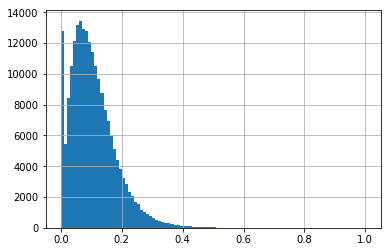

In [28]:
all_data['sim_scores'].hist(bins = 100)


## Sentiment

In [29]:
senti = []

for line in all_data['comment']:
    b = TextBlob(line)
    senti.append(b.sentiment.polarity)
            

In [30]:
all_data['sentiment'] = senti

In [31]:
all_data.head()

,title_index,user,comment,sim_scores,sentiment
0,062dd0f773cd5999a09714a371e1f8017163e2a1,3b6dbeb2375b632ad5f9dc9d15a9aa94872785a8,Doesn't gunfire produce visual illumination as...,0.268601,0.133333
1,062dd0f773cd5999a09714a371e1f8017163e2a1,e85b0a70877bfa83adaa5addae46e5c35a3d41b5,That's a good question. I have a question for ...,0.362450,0.100000
2,062dd0f773cd5999a09714a371e1f8017163e2a1,6b3269077e6a58a02aa2e06bd4dec6d3c08d248f,"As a former illusion designer, I can tell you ...",0.223119,0.000000
3,062dd0f773cd5999a09714a371e1f8017163e2a1,77b4bd37440e730458a65d372b7b1949c7d70537,"I also thought about it, and I guess what we i...",0.220757,0.500000
4,062dd0f773cd5999a09714a371e1f8017163e2a1,30324bcbe4f8e4ecf3268f8ff7fb4420c2e1067e,"He's wrong, the first video coverage of the wo...",0.297167,0.138961


In [32]:
#all_data.to_csv("all_data.csv")

### K-means

In [33]:
from sklearn.cluster import KMeans
X = np.array([all_data['sim_scores'], all_data['sentiment']])

In [34]:
_X = np.transpose(X)

### k = 6

In [35]:
kmeans = KMeans(n_clusters = 6, random_state = 0).fit(_X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(centroids)
print(labels)

[[ 0.07921856  0.00441822]
 [ 0.09185084  0.45385598]
 [ 0.21301015  0.12578141]
 [ 0.05893264  0.82215425]
 [ 0.09288281  0.22033091]
 [ 0.07383011 -0.34253121]]
[2 2 2 ... 0 2 4]


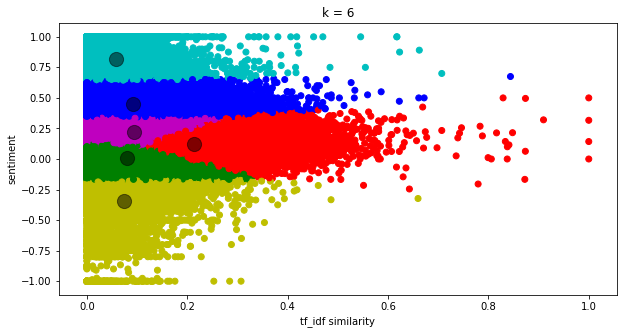

In [36]:
plt.figure(figsize = (10,5))
label_c = {0: 'g', 1: 'b', 2: 'r', 3: 'c', 4: 'm', 5: 'y'}
label_color = [label_c[l] for l in labels]
plt.scatter(_X[:,0], _X[:,1], c=label_color)
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel("tf_idf similarity")
plt.ylabel("sentiment")
plt.title("k = 6")
plt.show()

The more similar comments are to the transcript, the more neutral the comment becomes. Comments that are high or low in sentiment tend to be low in relevance. Green and Purple seem to be very close together, and may not really represent differnet classes. But by removing 1 class, Centroid 3 gets becomes lowers on the x axis.

Text(0.5,1,'The Elbow Method showing the optimal k')

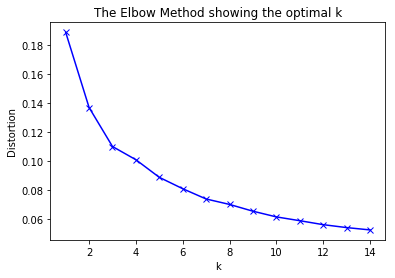

In [38]:
from scipy.spatial.distance import cdist
# k means determine k
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(_X)
    kmeanModel.fit(_X)
    distortions.append(sum(np.min(cdist(_X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / _X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

https://pythonprogramminglanguage.com/kmeans-elbow-method/

The centroid for class 5 moved up a smiggen , but not by much.